In [1]:
import pandas as pd 
from selenobot.utils import DATA_DIR, SCRIPTS_DIR, dataframe_from_fasta
from selenobot.sequences import *
import os
import numpy as np
import subprocess
import time
from tqdm import tqdm 
import matplotlib.pyplot as plt
import warnings 
import sklearn
import pickle


warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Set the main data directory to be the v3 validation directory. 
# TODO: Should I offload more of the helper functions to a separate file?
# organism = 'Btheta'
organism='acidovorax_3H11'
VAL_DIR = os.path.join(DATA_DIR, 'val3') 

In [2]:
predictions_df = pd.read_csv(os.path.join(VAL_DIR, organism, 'predictions.csv')) # , dtype={'id':str}) # Load selenoprotein predictions.
genome_df = dataframe_from_fasta(os.path.join(VAL_DIR, organism, f'genome.fna'), parser=None) 
metadata_df = pd.read_csv(os.path.join(VAL_DIR, organism, 'metadata.csv')) # , dtype={'id':str, 'scaffold_id':str}) 

print('Number of predicted selenoproteins:', np.sum(predictions_df.prediction.values))
print('Average length of predicted selenoproteins:', predictions_df[predictions_df.prediction == 1].seq.apply(len).mean())
print('Average length of predicted non-selenoproteins:', predictions_df[predictions_df.prediction == 0].seq.apply(len).mean()) 

Number of predicted selenoproteins: 55.0
Average length of predicted selenoproteins: 75.43636363636364
Average length of predicted non-selenoproteins: 318.8684049704624


## Extending predicted selenoproteins

In [3]:
sec_ids = predictions_df[predictions_df.prediction == 1]['id'].values # Get the IDs of the predicted selenoproteins. 
sec_cseqs = load_cseqs(metadata_df, genome_df=genome_df, use_ids=sec_ids)

load_cseqs: 100%|██████████| 55/55 [00:00<00:00, 157.68it/s]


In [ ]:
# How many of the non-extended 

In [74]:
# https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-9-335


[autoreload of selenobot.sequences failed: Traceback (most recent call last):
  File "/home/prichter/miniconda3/envs/selenobot/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/prichter/miniconda3/envs/selenobot/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/prichter/miniconda3/envs/selenobot/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/prichter/miniconda3/envs/selenobot/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/prichter/miniconda3/envs/selenobot/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/prichter/miniconda3/envs/selenobot/lib/python3.9/site-packages/IP

## Analyzing fitness data

There are several requirements that a hit must meet in order to be useful.
1. The sequence must be "extendable," i.e. the hit must not run off the end of the contig.
2. There must have been a transposon insertion in the extended region of the gene. 
3. The gene must create some kind of noticable phenotype when mutated.
4. 
I am thinking about adding an additional requirement, which is that the extended region does not overlap with another gene.

I need to think a little more about if I should adjust the "significant phenotype" standards. In the original paper, they use a minimum t value of 4 and fitness of 0.5, but when I apply this filtering to the selenoprotein hits, I only have a single result. I might try ignoring or loosening the significance constraint when looking at the predicted selenoprotein genes.

### Positive controls

Split the (non-extended) selenoprotein hits in two, and compute cofitness scores for the front half of the gene relative to back half of the gene. 

### Negative controls

For negative controls, extend non-selenoprotein hits to the next stop codon and look at the cofitness score for the extended region versus the main protein. 

In [48]:
fitness_df = pd.read_csv(os.path.join(VAL_DIR, organism, 'fitness.csv')) # , dtype={'id':str, 'scaffold_id':str})
t_values_df = pd.read_csv(os.path.join(VAL_DIR, organism, 't_values.csv')) # , dtype={'id':str})

# # Because of the NaN values, need to manually convert the IDs to strings.
# fitness_df['id'] = fitness_df['id'].apply(lambda id_ : None if pd.isnull(id_) else str(id_).split('.')[0])

In [57]:
# NOTE: I wonder if I should apply any other filters, like maybe number of hits in the extended region. 

negative_control_ids, negative_control_cofitness, negative_control_linregs = [], [], []

# Iterate over all sequences which are not predicted selenoproteins for the negative control. 
pbar = tqdm([id_ for id_ in fitness_df['id'].dropna().unique() if not (id_ in sec_ids)], desc='Filtering ContextSequences...')
for id_ in pbar:
    fbseq = FitnessBrowserSequence(id_, metadata_df=metadata_df, fitness_df=fitness_df, genome_df=genome_df, t_values_df=t_values_df, low_memory=False)

    if not fbseq.extendable():
        continue

    fbseq_extension = fbseq.extend().extension() 
    
    if fbseq.t_values is None:
        continue

    has_significant_phenotype = fbseq.significance() > 0
    has_hits_in_extended_region = fbseq_ext_only.hits() > 0
    has_hits_in_main_region = fbseq.hits() > 0
    does_not_overlap = fbseq_extension.overlap() == 0
    

    if all([has_significant_phenotype, has_hits_in_extended_region, has_hits_in_main_region, does_not_overlap]):
        negative_control_ids.append(id_)
        cofitness, linreg = fbseq.cofitness(fbseq_ext_only)
        negative_control_linregs.append(linreg)
        negative_control_cofitness.append(cofitness)

    pbar.set_description(f'Filtering ContextSequences... {len(negative_control_ids)} in final list.')

print('Saving negative_control_ids to', os.path.join(VAL_DIR, organism, 'negative_control_ids.csv'))
np.savetxt(os.path.join(VAL_DIR, organism, 'negative_control_ids.csv'), negative_control_ids, delimiter=',', fmt='%s')

print('Saving negative_control_linregs to', os.path.join(VAL_DIR, organism, 'negative_control_linregs.pkl'))
with open(os.path.join(VAL_DIR, organism, 'negative_control_linregs.pkl'), 'wb') as f:
    pickle.dump(negative_control_linregs, f)

print('Saving negative_control_cofitness to', os.path.join(VAL_DIR, organism, 'negative_control_cofitness.csv'))
np.savetxt(os.path.join(VAL_DIR, organism, 'negative_control_cofitness.csv'), negative_control_cofitness, delimiter=',')

Filtering ContextSequences... 1 in final list.:   0%|          | 12/4384 [00:08<41:08,  1.77it/s] 

0


Filtering ContextSequences... 2 in final list.:   0%|          | 14/4384 [00:09<40:18,  1.81it/s]

0


Filtering ContextSequences... 3 in final list.:   0%|          | 15/4384 [00:09<38:03,  1.91it/s]

0


Filtering ContextSequences... 4 in final list.:   0%|          | 16/4384 [00:10<37:00,  1.97it/s]

0


Filtering ContextSequences... 5 in final list.:   0%|          | 17/4384 [00:10<37:58,  1.92it/s]

0


Filtering ContextSequences... 6 in final list.:   1%|          | 46/4384 [00:22<28:59,  2.49it/s]

0


Filtering ContextSequences... 7 in final list.:   1%|          | 49/4384 [00:23<29:10,  2.48it/s]

0


Filtering ContextSequences... 7 in final list.:   1%|▏         | 56/4384 [00:27<35:08,  2.05it/s]


KeyboardInterrupt: 

In [54]:
sec_ids, sec_linregs, sec_cofitness = [], [], []

# Iterate over all predicted selenoproteins.
pbar = tqdm(predictions_df[predictions_df.prediction == 1]['id'].values, desc='Filtering ContextSequences...')
for id_ in pbar:
    cseq = ContextSequence(id_, metadata_df=metadata_df, genome_df=genome_df)

    if not cseq.extendable():
        continue
    
    cseq_ext_only = cseq.extend().extension()

    fbseq = FitnessBrowserSequence.from_cseq(cseq, fitness_df=fitness_df, t_values_df=t_values_df, low_memory=True)
    fbseq_ext_only = FitnessBrowserSequence.from_cseq(cseq_ext_only, fitness_df=fitness_df, t_values_df=t_values_df, low_memory=True)
    
    if fbseq.t_values is None:
        continue

    # has_significant_phenotype = fbseq.significance() > 0
    has_hits_in_extended_region = fbseq_ext_only.hits() > 0
    has_hits_in_main_region = fbseq.hits() > 0

    if has_hits_in_extended_region and has_hits_in_main_region:
        sec_ids.append(id_)
        cofitness, linreg = fbseq.cofitness(fbseq_ext_only)
        sec_linregs.append(linreg)
        sec_cofitness.append(cofitness)

    pbar.set_description(f'Filtering ContextSequences... {len(sec_ids)} in final list.')

print('Saving sec_ids to', os.path.join(VAL_DIR, organism, 'sec_ids.csv'))
np.savetxt(os.path.join(VAL_DIR, organism, 'sec_ids.csv'), sec_ids, delimiter=',', fmt='%s')
sec_ids = np.loadtxt(os.path.join(VAL_DIR, organism, 'sec_ids.csv'), dtype=str)

print('Saving sec_linregs to', os.path.join(VAL_DIR, organism, 'sec_linregs.pkl'))
with open(os.path.join(VAL_DIR, organism, 'sec_linregs.pkl'), 'wb') as f:
    pickle.dump(sec_linregs, f)

print('Saving sec_cofitness to', os.path.join(VAL_DIR, organism, 'sec_cofitness.csv'))
np.savetxt(os.path.join(VAL_DIR, organism, 'sec_cofitness.csv'), sec_cofitness, delimiter=',')
sec_cofitness = np.loadtxt(os.path.join(VAL_DIR, organism, 'sec_cofitness.csv'), dtype=float)

Filtering ContextSequences... 6 in final list.: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]

Saving sec_ids to /home/prichter/Documents/selenobot/selenobot/../data/val3/Btheta/sec_ids.csv
Saving sec_linregs to /home/prichter/Documents/selenobot/selenobot/../data/val3/Btheta/sec_linregs.pkl
Saving sec_cofitness to /home/prichter/Documents/selenobot/selenobot/../data/val3/Btheta/sec_cofitness.csv


In [55]:
print('Mean negative control cofitness:', np.mean(negative_control_cofitness))
print('Mean predicted selenoprotein cofitness:', np.mean(sec_cofitness))

Mean negative control cofitness: 0.23727610671400204
Mean predicted selenoprotein cofitness: 0.2192953935021326


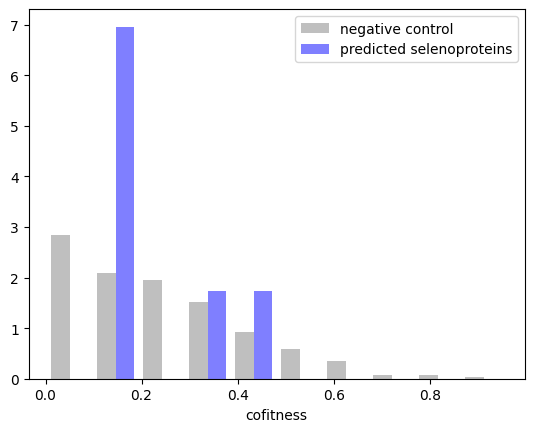

In [56]:
fig, ax = plt.subplots()
vals, _, _ = ax.hist((negative_control_cofitness, sec_cofitness), density=True, color=['gray', 'blue'], alpha=0.5)
ax.legend(['negative control', 'predicted selenoproteins'])
ax.set_xlabel('cofitness')
plt.show()

In [40]:
negative_control_cofitness = np.loadtxt(os.path.join(VAL_DIR, organism, 'negative_control_cofitness.csv'), dtype=float)
# negative_control_ids = np.loadtxt(os.path.join(VAL_DIR, organism, 'negative_control_ids.csv'), dtype=str)
with open(os.path.join(VAL_DIR, organism, 'negative_control_linregs.pkl'), 'rb') as f:
    negative_control_linregs = pickle.load(f)

# positive_control_cofitness = np.loadtxt(os.path.join(VAL_DIR, organism, 'positive_control_cofitness.csv'), dtype=float)
# positive_control_ids = np.loadtxt(os.path.join(VAL_DIR, organism, 'positive_control_ids.csv'), dtype=str)
# with open(os.path.join(VAL_DIR, organism, 'positive_control_linregs.pkl'), 'rb') as f:
#     positive_control_linregs = pickle.load(f)

sec_cofitness = np.loadtxt(os.path.join(VAL_DIR, organism, 'sec_cofitness.csv'), dtype=float)
sec_ids = np.loadtxt(os.path.join(VAL_DIR, organism, 'sec_ids.csv'), dtype=str)
# sec_ids = np.array([int(id_) for id_ in sec_ids]) # Only for the organisms for which the IDs are integers. 
with open(os.path.join(VAL_DIR, organism, 'sec_linregs.pkl'), 'rb') as f:
    sec_linregs = pickle.load(f)

In [59]:
sec_fbseqs = load_fbseqs(metadata_df, fitness_df, t_values_df=t_values_df, genome_df=genome_df, use_ids=sec_ids)
sec_fbseqs_extended = [fbseq.extend() for fbseq in sec_fbseqs if fbseq.extendable()]

load_fbseqs: 100%|██████████| 17/17 [00:08<00:00,  2.01it/s]


In [70]:
for fbseq, fbseq_extended in zip(sec_fbseqs, sec_fbseqs_extended):
    print(fbseq.id_)
    # print(f'Overlap in non-extended sequence:', fbseq.overlap()) # Confirmed that these were all zero. 
    print(f'Overlap in extended sequence:', fbseq_extended.overlap())
    print(f'Extension length:', len(fbseq_extended) - len(fbseq))
    if fbseq_extended.overlap() > 0:
        print(f'Overlap with {fbseq.next().id_} {fbseq.next().desc} of length {len(fbseq.next())}')
    print()

Ac3H11_4581
Overlap in extended sequence: 291
Extension length: 444
Overlap with Ac3H11_4580 hypothetical protein of length 291

Ac3H11_4637
Overlap in extended sequence: 0
Extension length: 240

Ac3H11_1967
Overlap in extended sequence: 0
Extension length: 1098

Ac3H11_2080
Overlap in extended sequence: 0
Extension length: 81

Ac3H11_2730
Overlap in extended sequence: 0
Extension length: 156

Ac3H11_2874
Overlap in extended sequence: 0
Extension length: 162

Ac3H11_1463
Overlap in extended sequence: 0
Extension length: 48

Ac3H11_4237
Overlap in extended sequence: 0
Extension length: 162

Ac3H11_4306
Overlap in extended sequence: 41
Extension length: 117
Overlap with Ac3H11_4307 Major membrane protein I of length 933

Ac3H11_3088
Overlap in extended sequence: 0
Extension length: 132

Ac3H11_4888
Overlap in extended sequence: 0
Extension length: 39

Ac3H11_4927
Overlap in extended sequence: 960
Extension length: 990
Overlap with Ac3H11_4928 LysR family transcriptional regulator STM3121

In [42]:
for id_, linreg in zip(sec_ids, sec_linregs):
    print(id_, linreg.slope)

Ac3H11_1463 0.19395658830946594
Ac3H11_1967 -0.17400389551529713
Ac3H11_2080 -0.04044371818345927
Ac3H11_2730 -0.1348735945928379
Ac3H11_2874 -0.038446868358168546
Ac3H11_3088 -0.056309440884745376
Ac3H11_3311 -0.022354904700408657
Ac3H11_3538 0.1839784021850656
Ac3H11_3718 -0.0035930292446034458
Ac3H11_3786 -0.09247398808560173
Ac3H11_4237 0.1056121641221724
Ac3H11_4306 0.1286271362772494
Ac3H11_4581 0.25289994713904124
Ac3H11_4637 0.16522297194280058
Ac3H11_4888 -0.109376461123247
Ac3H11_4927 0.1010919458377296
Ac3H11_4957 0.4750884675697945


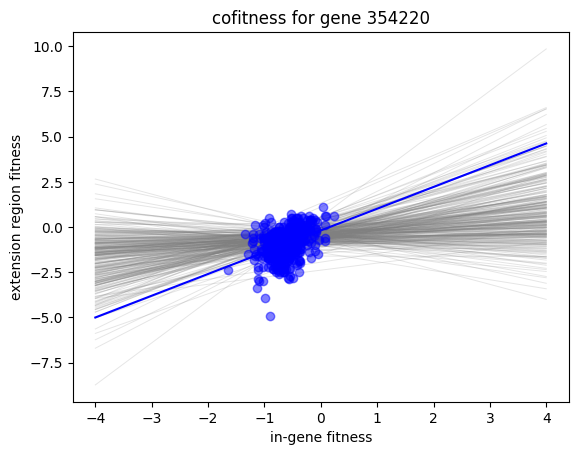

In [80]:
def plot_cofitness(id_:str):

    fig, ax = plt.subplots()

    x_vals = np.linspace(-4, 4, 50)

    for i, linreg in enumerate(negative_control_linregs):
        # fbseq = FitnessBrowserSequence.from_cseq(negative_control_cseqs[i], fitness_df, t_values_df=t_values_df)
        # fbseq_ext_only = FitnessBrowserSequence.from_cseq(negative_control_cseqs_ext_only[i], fitness_df, t_values_df=t_values_df)

        # ax.scatter(fbseq.mean(), fbseq_ext_only.mean(), color='gray', alpha=0.2, s=2)
        ax.plot(x_vals, x_vals * linreg.slope + linreg.intercept, color='gray', alpha=0.2, lw=0.7, zorder=1)

    # i = np.where(positive_control_ids == id_)[0].item()
    # positive_control_linreg = positive_control_linregs[i]
    # positive_control_cseq_left, positive_control_cseq_right = positive_control_cseqs_split[i]
    # positive_control_fbseq_left = FitnessBrowserSequence.from_cseq(positive_control_cseq_left, fitness_df, t_values_df=t_values_df) 
    # positive_control_fbseq_right = FitnessBrowserSequence.from_cseq(positive_control_cseq_right, fitness_df, t_values_df=t_values_df) 
    # ax.scatter(positive_control_fbseq_left.mean(), positive_control_fbseq_right.mean(), color='black', alpha=0.5)
    # ax.plot(x_vals, x_vals * linreg.slope + linreg.intercept, color='black')
    i = np.where(sec_ids == id_)[0].item()
    sec_linreg = sec_linregs[i]
    sec_fbseq = FitnessBrowserSequence.from_cseq(sec_cseqs[i], fitness_df, t_values_df=t_values_df)
    sec_fbseq_ext_only = FitnessBrowserSequence.from_cseq(sec_cseqs_ext_only[i], fitness_df, t_values_df=t_values_df)
    ax.scatter(sec_fbseq.mean(), sec_fbseq_ext_only.mean(), color='blue', alpha=0.5, zorder=3)
    ax.plot(x_vals, x_vals * sec_linreg.slope + sec_linreg.intercept, color='blue', zorder=2)

    ax.set_xlabel('in-gene fitness')
    ax.set_ylabel('extension region fitness')
    ax.set_title(f'cofitness for gene {id_}')


plot_cofitness(354220)

# There do seem to be some outliers in the slopes. I wonder if we should be using "distance from a slope of 1" as
# the metric, as a one-to-one correspondence should probably be the target. Also, there do seem to be 
# outliers in the negative control cofitness values -- perhaps the extension region is overlapping another gene?
# Maybe I should remove these cases as well, and make sure the flagged selenoproteins are also not overlapping.

In [27]:
def get_p_value_cofitness(id_):
    '''Compute the significance of the cofitness value considering the distribution of negative control 
    cofitness values. These are correlation coefficients, so no need to use a pivotal test statistic.''' 
    negative_control_cofitness = np.loadtxt(os.path.join(VAL_DIR, organism, 'negative_control_cofitness.csv'), dtype=float)
    sec_cofitness = np.loadtxt(os.path.join(VAL_DIR, organism, 'sec_cofitness.csv'), dtype=float)
    sec_ids = np.loadtxt(os.path.join(VAL_DIR, organism, 'sec_ids.csv'), dtype=str)
    sec_ids = np.array([int(id_) for id_ in sec_ids]) # Only for the organisms for which the IDs are integers. 

    cofitness = sec_cofitness[sec_ids == id_] # Get the cofitness score for the specified locus. 

    p = np.sum(negative_control_cofitness > cofitness) # Get the number of cofitness values more extreme than that of the predicted selenoprotein. 
    p = p / (len(negative_control_cofitness))
    return p


def get_p_value_slope(id_):
    '''Compute the significance of the slope considering the distribution of negative control 
    slopes (from fitting linear regression models).''' 
    with open(os.path.join(VAL_DIR, organism, 'negative_control_linregs.pkl'), 'rb') as f:
        negative_control_linregs = pickle.load(f)
    negative_control_slopes = np.array([linreg.slope for linreg in negative_control_linregs])
    with open(os.path.join(VAL_DIR, organism, 'sec_linregs.pkl'), 'rb') as f:
        sec_linregs = pickle.load(f)
    sec_slopes = np.array([linreg.slope for linreg in sec_linregs])

    sec_ids = np.loadtxt(os.path.join(VAL_DIR, organism, 'sec_ids.csv'), dtype=str)
    sec_ids = np.array([int(id_) for id_ in sec_ids]) # Only for the organisms for which the IDs are integers. 

    slope = sec_slopes[sec_ids == id_]
    p = np.sum(negative_control_slopes > slope)
    p = p / len(negative_control_slopes)

    return p

In [51]:
FitnessBrowserSequence.from_cseq(sec_cseqs[4], fitness_df).fitness

,set1IT049,set1IT050,set1IT051,set1IT052,set1IT053,set1IT055,set1IT056,set1IT057,set1IT058,set1IT059,...,set4IT075,set4IT077,set4IT078,set4IT080,set4IT081,set4IT083,set4IT084,set4IT086,set4IT090,set4IT092
id,,,,,,,,,,,,,,,,,,,,,
Ac3H11_2730,1.0,0.2,0.2,0.1,-0.7,-1.5,-0.2,-0.5,-0.7,-2.7,...,0.2,-1.1,-2.4,1.1,-1.4,0.4,-0.3,-1.0,0.1,-1.3
Ac3H11_2730,-1.5,1.2,1.9,0.0,-0.6,0.3,-0.4,0.1,-0.1,0.9,...,0.1,0.2,-2.3,-0.3,1.0,1.2,0.1,0.8,0.4,-1.3
Ac3H11_2730,0.9,0.2,0.8,-0.4,-0.1,-1.0,0.2,0.4,-0.3,-1.4,...,0.0,-0.4,-0.1,0.8,-0.0,0.6,0.5,-1.4,-0.8,0.5


In [49]:
sec_ids[0] == 349816

False

In [2]:
# TODO: Try splitting up in-gene observations and seeing if there is any correlation with those.
# TODO: In an attempt to reduce noise, try filtering using t-values. 
# TODO: Some kind of interference score to quantify how much of the downstream region is occupied by another gene.
# TODO: Compare to in-gene fitness values.
# TODO: Color-code experiment observations by category. 
# TODO: Maybe consider using the number of transposon mutations in the downstream region as a way to indicate if a region is useful?
# TODO: Maybe compare stop codon usage among hits to stop codon usage across the genome?

In [3]:

# positive_control_ids, positive_control_cofitness, positive_control_linregs = [], [], []

# # Iterate over all predicted selenoproteins.
# pbar = tqdm(predictions_df[predictions_df.prediction == 1]['id'].values, desc='Filtering ContextSequences...')
# for id_ in pbar:
#     cseq = ContextSequence(id_, metadata_df=metadata_df, genome_df=genome_df)
#     left_cseq, right_cseq = cseq.split() # Split the gene in two. 
#     # Convert to FitnessBrowserSequence objects to compute cofitness. 
#     left_fbseq = FitnessBrowserSequence.from_cseq(left_cseq, fitness_df, t_values_df=t_values_df)
#     right_fbseq = FitnessBrowserSequence.from_cseq(right_cseq, fitness_df, t_values_df=t_values_df)

#     if (left_fbseq.t_values is not None) and (right_fbseq.t_values is not None):
#         # has_significant_phenotype = fbseq.significance() > 0
#         # print('has_significant_phenotype:', has_significant_phenotype)
#         has_hits_in_both_regions = (right_fbseq.hits() > 0) and (left_fbseq.hits() > 0)

#         if has_hits_in_both_regions:
#             positive_control_ids.append(id_) 
#             cofitness, linreg = left_fbseq.cofitness(right_fbseq)
#             positive_control_cofitness.append(cofitness)
#             positive_control_linregs.append(linreg)

#     pbar.set_description(f'Filtering ContextSequences... {len(positive_control_ids)} in final list.')


# print('Saving positive_control_ids to', os.path.join(VAL_DIR, organism, 'positive_control_ids.csv'))
# np.savetxt(os.path.join(VAL_DIR, organism, 'positive_control_ids.csv'), positive_control_ids, delimiter=',', fmt='%s')
# sec_ids = np.loadtxt(os.path.join(VAL_DIR, organism, 'positive_control_ids.csv'), dtype=str)

# print('Saving positive_control_linregs to', os.path.join(VAL_DIR, organism, 'positive_control_linregs.pkl'))
# with open(os.path.join(VAL_DIR, organism, 'positive_control_linregs.pkl'), 'wb') as f:
#     pickle.dump(positive_control_linregs, f)

# print('Saving positive_control_cofitness to', os.path.join(VAL_DIR, organism, 'positive_control_cofitness.csv'))
# np.savetxt(os.path.join(VAL_DIR, organism, 'positive_control_cofitness.csv'), positive_control_cofitness, delimiter=',')
# sec_cofitness = np.loadtxt(os.path.join(VAL_DIR, organism, 'positive_control_cofitness.csv'), dtype=float)